# Load and check data

In [1]:
import time
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

import nltk

from sklearn import metrics, model_selection, naive_bayes
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import xgboost as xgb

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(train.shape[0]))
print("Number of rows in test dataset {}".format(test.shape[0]))
print("No duplicates in train data") if train.shape[0] == train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test.shape[0] == test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(train.isnull().sum().sum(), test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


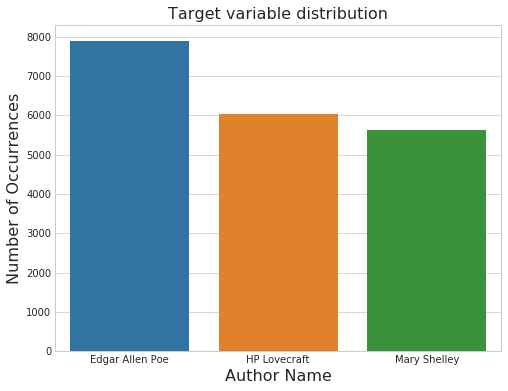

In [4]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=train.author.map(z).unique(), y=train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

In [5]:
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

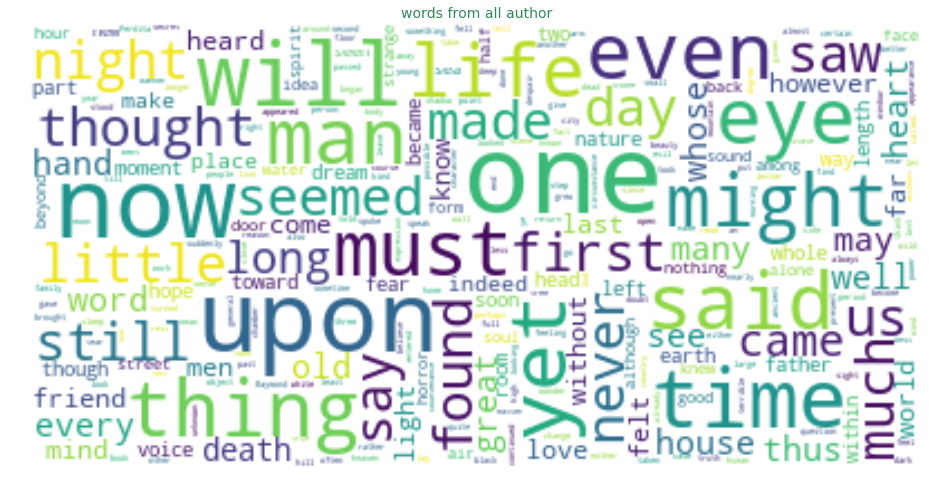

In [6]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [7]:
img1 = imread("eap.png")
img2 = imread("mws.png")
img3 = imread("hpl.png")

In [8]:
eap = train[train.author == "EAP"]["text"].values
mws = train[train.author == "MWS"]["text"].values
hpl = train[train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

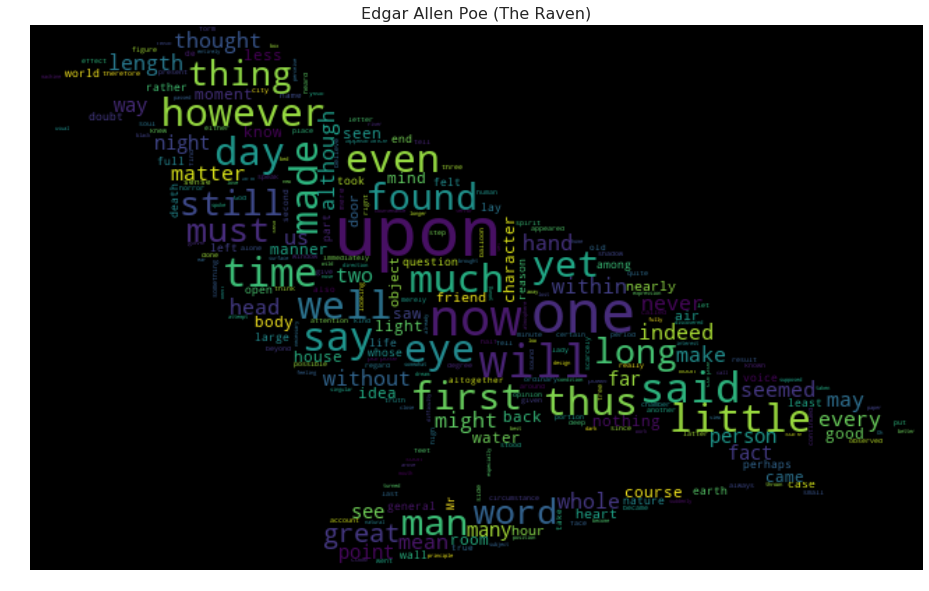

In [9]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

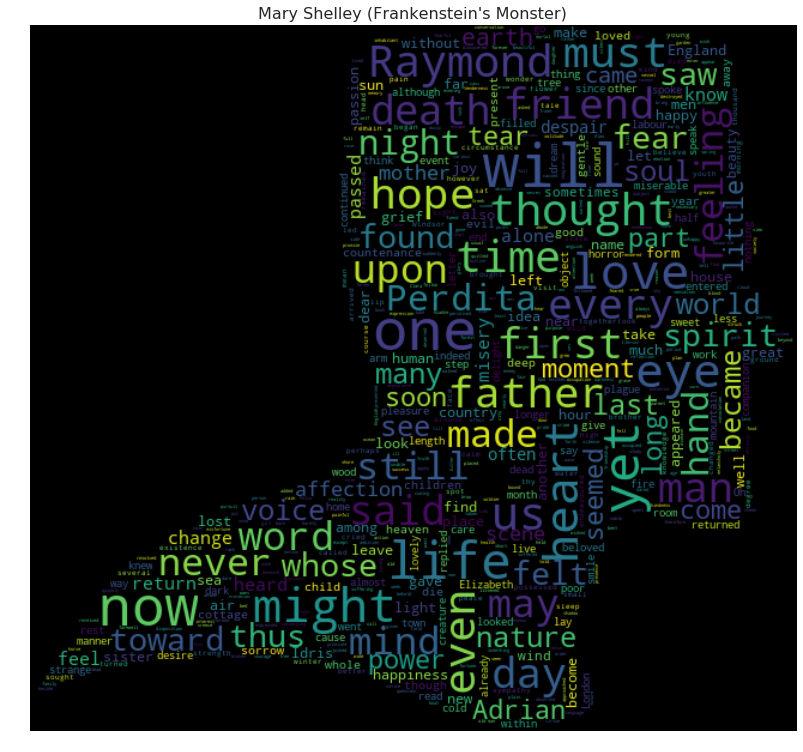

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

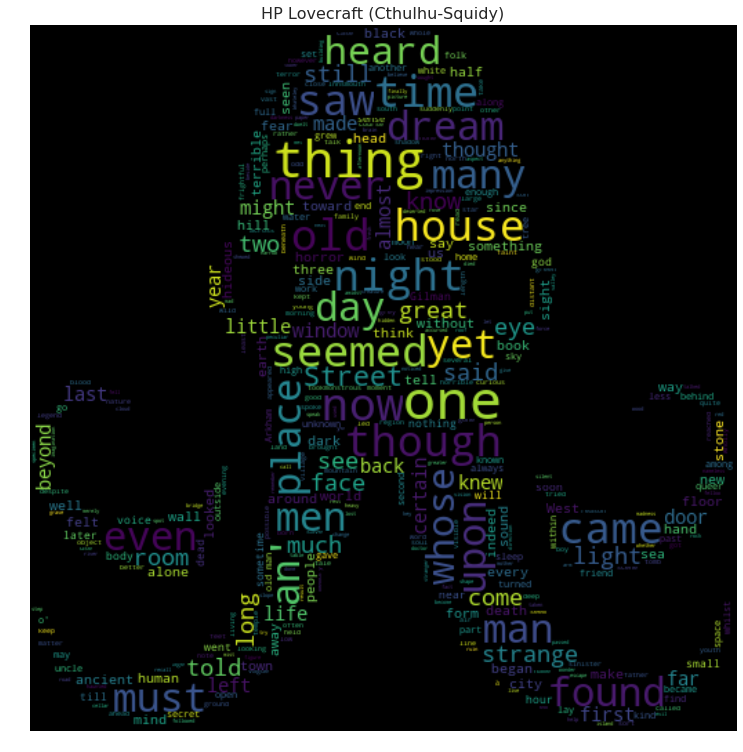

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [12]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [13]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [15]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [16]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [37]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [18]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [19]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Fuctions

## Confusion Matrix

In [5]:
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Multinomial Naive Bayes

In [6]:
def runMNB(x_train, y_train, x_val, x_test):
    model = naive_bayes.MultinomialNB()
    model.fit(x_train, y_train)
    pred_y_val = model.predict_proba(x_val)
    pred_y_test = model.predict_proba(x_test)
    return pred_y_val, pred_y_test, model

## XGBoost

In [7]:
xgb_param = {
    'min_child_weight': 1,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 3,
    'subsample': 0.8,
    'lambda': 2.0,
    'nthread': -1,
    'silent': 1,
    'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    'num_class': 3
}


def runXGB(x_train, y_train, x_val, y_val, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, y_val)
    dtest = xgb.DMatrix(x_test)
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        xgb_param,
        dtrain,
        2000,
        watchlist,
        early_stopping_rounds=50,
        maximize=False,
        verbose_eval=40)
    pred_y_val = model.predict(dval, ntree_limit=model.best_ntree_limit)
    pred_y_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    return pred_y_val, pred_y_test, model

# Feature Engineering

## --- Text based features ---

In [8]:
import string


def word_count(raw):
    return len(raw['text'].split())


def char_count(raw):
    return len(raw['text'])


def word_len_mean(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return np.mean([len(w) for w in text_list])


def unique_word_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len(list(set(text_list)))


def stopwords_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    return len([w for w in text_list if w in stopwords])


def punctuations_count(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    return len([w for w in text_list if w in string.punctuation])


def word_upper_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.isupper()])


def word_title_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.istitle()])


def unique_word_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    unique_word_count = len(list(set(text_list)))
    word_count = len(text_list)
    return unique_word_count / word_count


def stopwords_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_count = len([w for w in text_list if w in stopwords])
    word_count = len(text_list)
    return stopwords_count / word_count


def punctuations_fraction(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    punctuation_count = len([w for w in text_list if w in string.punctuation])
    char_count = len(text)
    return punctuation_count / char_count


def word_upper_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_upper_count = len([w for w in text_list if w.isupper()])
    word_count = len(text_list)
    return word_upper_count / word_count


def word_title_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_title_count = len([w for w in text_list if w.istitle()])
    word_count = len(text_list)
    return word_title_count / word_count


def noun_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    word_count = len(text_list)
    return noun_count / word_count


def adj_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    word_count = len(text_list)
    return adj_count / word_count


def verbs_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    word_count = len(text_list)
    return verbs_count / word_count

In [9]:
for dataset in full_data:
    dataset['word_count'] = dataset.apply(lambda raw: word_count(raw), axis=1)
    dataset['char_count'] = dataset.apply(lambda raw: char_count(raw), axis=1)
    dataset['word_len_mean'] = dataset.apply(lambda raw: word_len_mean(raw), axis=1)
    
    dataset['unique_word_count'] = dataset.apply(lambda raw: unique_word_count(raw), axis=1)
    dataset['stopwords_count'] = dataset.apply(lambda raw: stopwords_count(raw), axis=1)
    dataset['punctuations_count'] = dataset.apply(lambda raw: punctuations_count(raw), axis=1)
    dataset['word_upper_count'] = dataset.apply(lambda raw: word_upper_count(raw), axis=1)
    dataset['word_title_count'] = dataset.apply(lambda raw: word_title_count(raw), axis=1)
    
    dataset['unique_word_fraction'] = dataset.apply(lambda raw: unique_word_fraction(raw), axis=1)
    dataset['stopwords_fraction'] = dataset.apply(lambda raw: stopwords_fraction(raw), axis=1)
    dataset['punctuations_fraction'] = dataset.apply(lambda raw: punctuations_fraction(raw), axis=1)
    dataset['word_upper_fraction'] = dataset.apply(lambda raw: word_upper_fraction(raw), axis=1)
    dataset['word_title_fraction'] = dataset.apply(lambda raw: word_title_fraction(raw), axis=1)
    
    dataset['noun_fraction'] = dataset.apply(lambda raw: noun_fraction(raw), axis=1)
    dataset['adj_fraction'] = dataset.apply(lambda raw: adj_fraction(raw), axis=1)
    dataset['verbs_fraction'] = dataset.apply(lambda raw: verbs_fraction(raw), axis=1)

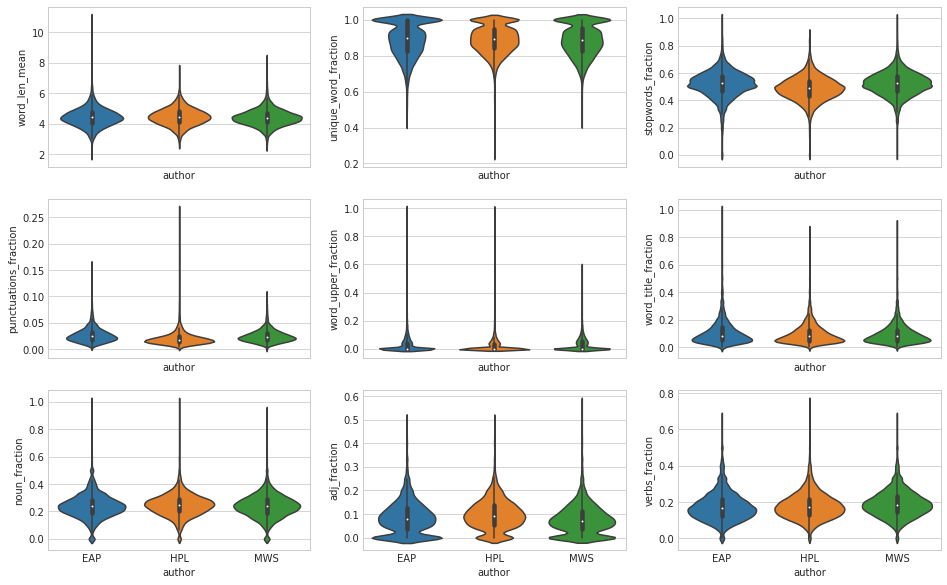

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x='author', y='word_len_mean', data=train, ax=ax[0, 0])
sns.violinplot(x='author', y='unique_word_fraction', data=train, ax=ax[0, 1])
sns.violinplot(x='author', y='stopwords_fraction', data=train, ax=ax[0, 2])

sns.violinplot(x='author', y='punctuations_fraction', data=train, ax=ax[1, 0])
sns.violinplot(x='author', y='word_upper_fraction', data=train, ax=ax[1, 1])
sns.violinplot(x='author', y='word_title_fraction', data=train, ax=ax[1, 2])

sns.violinplot(x='author', y='noun_fraction', data=train, ax=ax[2, 0])
sns.violinplot(x='author', y='adj_fraction', data=train, ax=ax[2, 1])
sns.violinplot(x='author', y='verbs_fraction', data=train, ax=ax[2, 2])

## XGBoost model using Text based features

In [11]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 16) (8392, 16)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,punctuations_fraction,word_upper_fraction,word_title_fraction,noun_fraction,adj_fraction,verbs_fraction
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,0.030303,0.04878,0.073171,0.292683,0.048780,0.146341
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,0.014085,0.00000,0.071429,0.142857,0.071429,0.142857
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,0.025000,0.00000,0.027778,0.277778,0.138889,0.111111
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,0.019417,0.00000,0.117647,0.294118,0.176471,0.147059
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,0.022989,0.00000,0.074074,0.222222,0.037037,0.222222


In [12]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.08762	val-mlogloss:1.08907
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.960029	val-mlogloss:0.984945
[80]	train-mlogloss:0.929692	val-mlogloss:0.967477
[120]	train-mlogloss:0.911581	val-mlogloss:0.959577
[160]	train-mlogloss:0.898984	val-mlogloss:0.956989
[200]	train-mlogloss:0.888438	val-mlogloss:0.955285
[240]	train-mlogloss:0.878812	val-mlogloss:0.954415
[280]	train-mlogloss:0.870162	val-mlogloss:0.954227
Stopping. Best iteration:
[259]	train-mlogloss:0.874821	val-mlogloss:0.953757

[0]	train-mlogloss:1.08797	val-mlogloss:1.08824
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.963335	val-mlogloss:0.974579
[80]	train-mlogloss:0.93324	val-mlogloss:0.953972
[120]	train-mlogloss:0.915465	val-mlogloss:0.94666
[160]	train-m

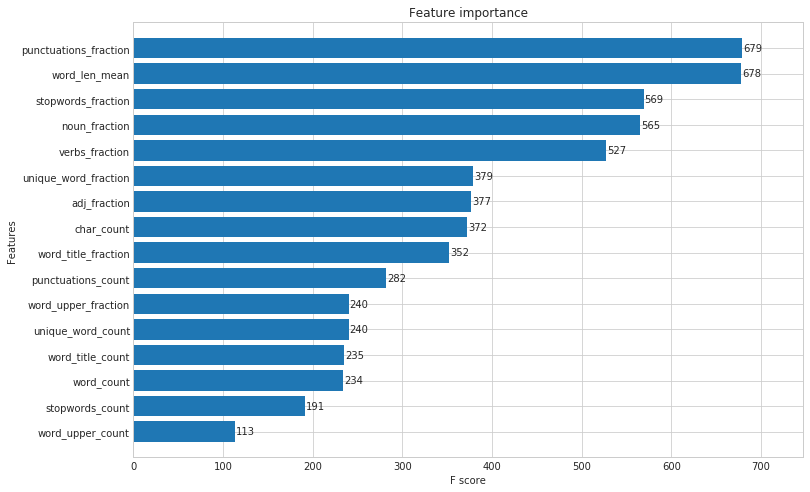

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

## --- word Count and TFIDF features ---

In [14]:
lemm = nltk.stem.WordNetLemmatizer()


class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


class LemmTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [15]:
# word vectorizer
tf_vectorizer = LemmCountVectorizer(stop_words='english', ngram_range=(1,3))
tf_train = tf_vectorizer.fit_transform(train['text'].values.tolist())
tf_test = tf_vectorizer.transform(test['text'].values.tolist())

tfidf_vectorizer = LemmTfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_train = tfidf_vectorizer.fit_transform(train['text'].values.tolist())
tfidf_test = tfidf_vectorizer.transform(test['text'].values.tolist())

## Naive Bayes model using word Count features

In [16]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tf_train):
    x_dev, x_val = tf_train[idx_dev], tf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.4581034305450692


In [17]:
# add the predictions as new features
train["nb_word_count_eap"] = pred_train[:,0]
train["nb_word_count_hpl"] = pred_train[:,1]
train["nb_word_count_mws"] = pred_train[:,2]
test["nb_word_count_eap"] = pred_full_test[:,0]
test["nb_word_count_hpl"] = pred_full_test[:,1]
test["nb_word_count_mws"] = pred_full_test[:,2]

Confusion matrix, without normalization
[[1308  110  177]
 [ 111  899   88]
 [ 121   50 1051]]


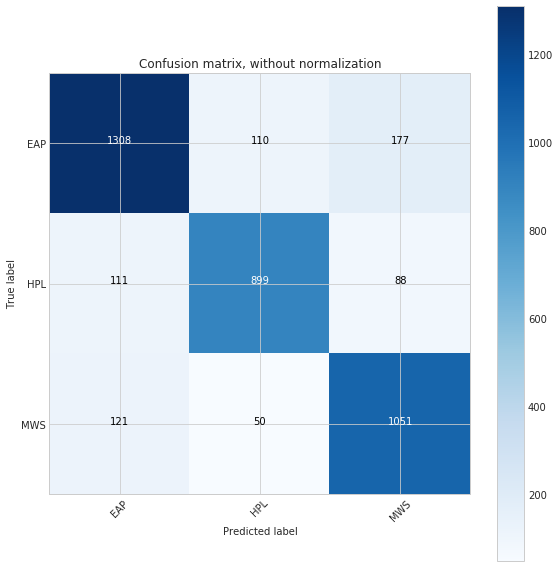

In [18]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using word TFIDF features

In [19]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfidf_train):
    x_dev, x_val = tfidf_train[idx_dev], tfidf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.8335510961069861


In [20]:
# add the predictions as new features
train["nb_word_tfidf_eap"] = pred_train[:,0]
train["nb_word_tfidf_hpl"] = pred_train[:,1]
train["nb_word_tfidf_mws"] = pred_train[:,2]
test["nb_word_tfidf_eap"] = pred_full_test[:,0]
test["nb_word_tfidf_hpl"] = pred_full_test[:,1]
test["nb_word_tfidf_mws"] = pred_full_test[:,2]

Confusion matrix, without normalization
[[1532   16   47]
 [ 522  530   46]
 [ 453   11  758]]


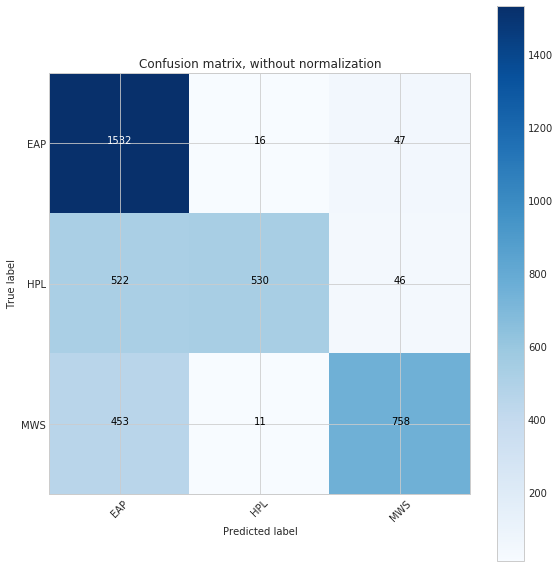

In [21]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## SVD on word TFIDF features

In [229]:
start = time.time()

n_comp = 40
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svd_train = svd.fit_transform(tfidf_train)
svd_test = svd.transform(tfidf_test)
svd_train_df = pd.DataFrame(svd_train)
svd_test_df = pd.DataFrame(svd_test)

svd_train_df.columns = ['svd_word_' + str(i) for i in range(n_comp)]
svd_test_df.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train = pd.concat([train, svd_train_df], axis=1)
test = pd.concat([test, svd_test_df], axis=1)

end = time.time()
print("Time taken in tf-idf is {}.".format(end - start))

Time taken in tf-idf is 1.982083797454834.


## --- char Count and TFIDF features ---

In [23]:
# char vectorizer
tfc_vectorizer = CountVectorizer(ngram_range=(1, 7), analyzer='char')
tfc_train = tfc_vectorizer.fit_transform(train['text'].values.tolist())
tfc_test = tfc_vectorizer.transform(test['text'].values.tolist())

tfidfc_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char')
tfidfc_train = tfidfc_vectorizer.fit_transform(train['text'].values.tolist())
tfidfc_test = tfidfc_vectorizer.transform(test['text'].values.tolist())

## Naive Bayes model using char Count features

In [24]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfc_train):
    x_dev, x_val = tfc_train[idx_dev], tfc_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfc_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 3.725182058538286


In [25]:
# add the predictions as new features
train["nb_char_count_eap"] = pred_train[:,0]
train["nb_char_count_hpl"] = pred_train[:,1]
train["nb_char_count_mws"] = pred_train[:,2]
test["nb_char_count_eap"] = pred_full_test[:,0]
test["nb_char_count_hpl"] = pred_full_test[:,1]
test["nb_char_count_mws"] = pred_full_test[:,2]

Confusion matrix, without normalization
[[1348   97  150]
 [ 141  887   70]
 [ 114   57 1051]]


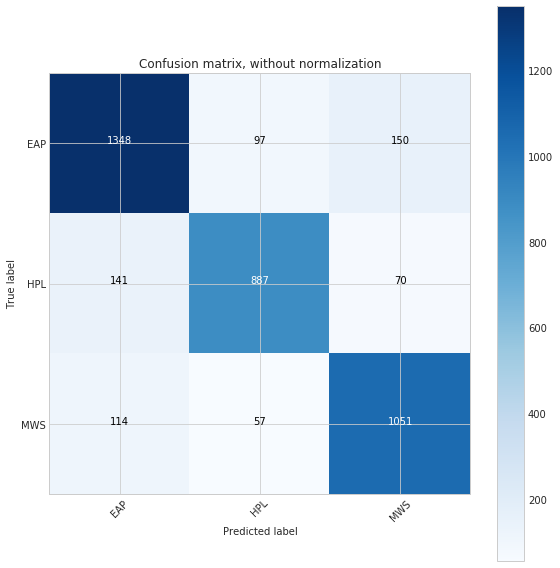

In [26]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using char TFIDF features

In [27]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfidfc_train):
    x_dev, x_val = tfidfc_train[idx_dev], tfidfc_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidfc_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.8924656818342923


In [28]:
# add the predictions as new features
train["nb_char_tfidf_eap"] = pred_train[:,0]
train["nb_char_tfidf_hpl"] = pred_train[:,1]
train["nb_char_tfidf_mws"] = pred_train[:,2]
test["nb_char_tfidf_eap"] = pred_full_test[:,0]
test["nb_char_tfidf_hpl"] = pred_full_test[:,1]
test["nb_char_tfidf_mws"] = pred_full_test[:,2]

Confusion matrix, without normalization
[[1578    2   15]
 [ 850  233   15]
 [ 798    4  420]]


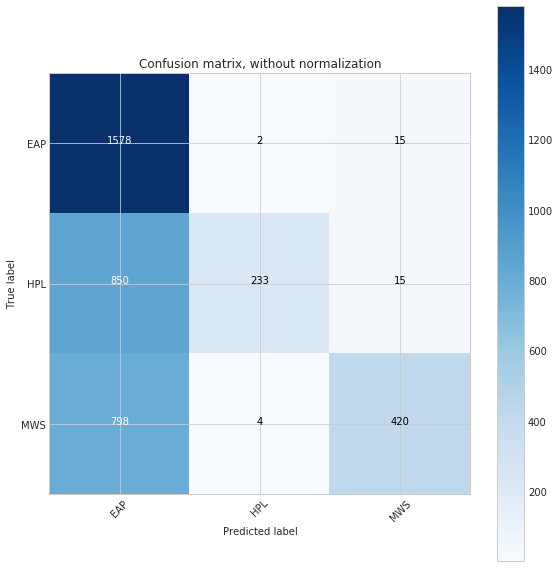

In [29]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## SVD on char TFIDF features

In [30]:
start = time.time()

n_comp = 40
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svd_train = svd.fit_transform(tfidfc_train)
svd_test = svd.transform(tfidfc_test)
svd_train_df = pd.DataFrame(svd_train)
svd_test_df = pd.DataFrame(svd_test)

svd_train_df.columns = ['svd_char_' + str(i) for i in range(n_comp)]
svd_test_df.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train = pd.concat([train, svd_train_df], axis=1)
test = pd.concat([test, svd_test_df], axis=1)

end = time.time()
print("Time taken in tf-idf is {}.".format(end - start))

Time taken in tf-idf is 37.14475059509277.


## --- Markov event based features ---

In [31]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

    def count(self, item):
        """Return the count of the given item in this histogram, or 0"""
        if item in self:
            return self[item]
        return 0

    def return_random_word(self):
        # Another way:  Should test: random.choice(histogram.keys())
        random_key = random.sample(self, 1)
        return random_key[0]

    def return_weighted_random_word(self):
        # Step 1: Generate random number between 0 and total count - 1
        random_int = random.randint(0, self.tokens - 1)
        index = 0
        list_of_keys = self.keys()
        # print 'the random index is:', random_int
        for i in range(0, self.types):
            index += self[list_of_keys[i]]
            # print index
            if (index > random_int):
                # print list_of_keys[i]
                return list_of_keys[i]

In [32]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for i in range(len(data) - order):
        # Create the window
        window = tuple(data[i:i + order])
        # Add to the dictionary
        if window in markov_model:
            # We have to just append to the existing Dictogram
            markov_model[window].update([data[i + order]])
        else:
            markov_model[window] = Dictogram([data[i + order]])
    return markov_model

In [193]:
def lemmed_and_tokenized_list(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    lemm = nltk.stem.WordNetLemmatizer()
    lemmed_text_list = [lemm.lemmatize(w) for w in text_list]

    return lemmed_text_list

In [198]:
full_data = [train, test]
order = 3

for dataset in full_data:
    dataset['splited_text'] = dataset.apply(lambda raw: lemmed_and_tokenized_list(raw), axis=1)
    
    
eap = train[train.author == 'EAP']['splited_text'].values
hpl = train[train.author == 'HPL']['splited_text'].values
mws = train[train.author == 'MWS']['splited_text'].values

flat_eap = []
[flat_eap.extend(w) for w in eap]
flat_hpl = []
[flat_hpl.extend(w) for w in hpl]
flat_mws = []
[flat_mws.extend(w) for w in mws]

eap_MM = make_higher_order_markov_model(flat_eap, order)
hpl_MM = make_higher_order_markov_model(flat_hpl, order)
mws_MM = make_higher_order_markov_model(flat_mws, order)

In [199]:
print(eap_MM[('no', 'mean', 'of')])
print(sum([x for x in eap_MM[('no', 'mean', 'of')].values()]))
print(eap_MM[('no', 'mean', 'of')]['the'])

{'ascertaining': 1, 'the': 1, 'calculating': 1, 'her': 1}
4
1


In [200]:
def spit_out_prob(tupl, word, mm1, mm2, mm3):
    """function to spit out a prob of a word given a tuple and a word and a markov model"""
    """fix this function, its working but not calculating probabilities, but providing
    some confidance index, greater than confidance index is, larger is the prob"""
    try:
        a = mm1[tupl][word]
    except:
        a = 0
    try:
        b = mm2[tupl][word]
    except:
        b = 0
    try:
        c = mm3[tupl][word]
    except:
        c = 0
    try:
        prob_word = a / (a + b + c)  #(sum([x for x in mm[tupl].values()]))
        return (prob_word)
    except:
        return (0)  #earlier it was 1


def make_tuples(sentence, order):
    """function to make tuples of n size given a sentence and n"""
    list_of_tuple = []
    words = []
    for i in range(len(sentence) - order):
        window = tuple(sentence[i:i + order])
        list_of_tuple.append(window)
        words.append(sentence[i + order])
    return (list_of_tuple, words)


def sent_to_prob(raw, author, order):
    """function to get the markov model to give prob of a author given a sentence """
    sentence = raw['splited_text']
    list_of_tuples, words = make_tuples(sentence, order)
    
    p = 0
    cnt = 0
    
    for i in range(len(words)):
        if author == 'eap':
            tmp = spit_out_prob(list_of_tuples[i], words[i], mm1=eap_MM, mm2=hpl_MM, mm3=mws_MM)
            p += tmp
        elif author == 'hpl':
            tmp = spit_out_prob(list_of_tuples[i], words[i], mm1=hpl_MM, mm2=eap_MM, mm3=mws_MM)
            p += tmp
        elif author == 'mws':
            tmp = spit_out_prob(list_of_tuples[i], words[i], mm1=mws_MM, mm2=eap_MM, mm3=hpl_MM)
            p += tmp
        if tmp != 0:
            cnt += 1
            
    if cnt != 0:
        return p / cnt
    else:
        return 0

In [205]:
for dataset in full_data:
    dataset['EAP_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'eap', order), axis=1)
    dataset['HPL_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'hpl', order), axis=1)
    dataset['MWS_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'mws', order), axis=1)

    del dataset['splited_text']

train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order), 'author']].head(10)

#EAP_markov_3  HPL_markov_3  MWS_markov_3 author
#0     38.000000      0.000000      0.000000    EAP
#1      1.466667      9.433333      0.100000    HPL
#2     32.692308      0.076923      0.230769    EAP
#3      0.000000      0.000000     31.000000    MWS
#4      0.500000     23.500000      0.000000    HPL
#5      1.000000      0.500000     78.500000    MWS
#6     17.250000      0.000000      0.750000    EAP
#7      5.000000      0.000000      0.000000    EAP
#8     85.000000      0.000000      0.000000    EAP
#9      0.000000      0.000000     20.000000    MWS

,EAP_markov_3,HPL_markov_3,MWS_markov_3,author
0,1.000000,0.000000,0.000000,EAP
1,0.733333,0.857576,0.100000,HPL
2,0.990676,0.076923,0.230769,EAP
3,0.000000,0.000000,1.000000,MWS
4,0.500000,0.979167,0.000000,HPL
5,0.500000,0.500000,0.981250,MWS
6,0.958333,0.000000,0.750000,EAP
7,1.000000,0.000000,0.000000,EAP
8,1.000000,0.000000,0.000000,EAP
9,0.000000,0.000000,1.000000,MWS


## lda TODO

In [20]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [21]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

In [22]:
#lda.fit(tfidf_train)
lda.fit(tf_train)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [23]:
n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Topics in LDA model: 

Topic #0: admiralty court streets admiration pity especially events nineteenth ah dearest friend action lingered account properly belong period life abstract conception account circumstances brought neglect father accomplished loss advanced truth argument acolyte bear brimming advanced bore small afterward reproduced associated advances time exuberant act hesitation vanished acquired knowledge addition raymond dispelled adduced support idea articles adorn mind person man fitted account patient condition acetylene headlight despite attention

Topic #1: adjoining staircase arrested attention addressed english voice affection undisturbed unchecked fear opened accompanied apparent rapid subsidence admonition singular low agreed understand passages act previous act accommodation man accompanied actions arising aged father adrian visited london came ah bon acts recovery agreed virtual identity phrase agora abnormal looking address noble persons mentioned husband absolu

In [24]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape

(13781,)

In [25]:
first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

In [26]:
for i in first_topic.argsort()[:-50 - 1:-1]:
    print(i)

7637
7730
13750
5618
3911
1936
3673
3222
9157
4785
9032
11688
9198
5324
5095
7000
7292
8367
3856
4573
139
11224
7394
11997
2745
13527
7623
6099
5252
846
4334
1472
2613
3248
5599
7299
2224
5479
11791
13511
13697
1394
7851
8326
5432
8416
5402
421
10506
12061


## --- Sentiment Analysis based features ---

# Ensembling & Stacking models

In [230]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

#drop_elements = ['id', 'text']
drop_elements = ['id', 'text', 'EAP_markov_3', 'HPL_markov_3', 'MWS_markov_3']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 128) (8392, 128)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,svd_word__10,svd_word__11,svd_word__12,svd_word__13,svd_word__14,svd_word__15,svd_word__16,svd_word__17,svd_word__18,svd_word__19
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,0.012881,0.000047,-0.009253,-0.007894,-0.002708,-0.017883,0.030351,-0.021336,0.018136,0.008252
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,-0.000724,-0.004331,0.000986,-0.001621,0.001532,-0.004008,0.002885,-0.003943,0.002243,0.002591
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,-0.014142,0.005959,-0.030201,-0.001078,-0.018837,-0.000321,0.015256,-0.003276,0.017823,-0.008163
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,-0.003089,-0.003364,0.000323,0.049754,0.005248,-0.008805,-0.016142,0.024814,-0.010564,-0.014910
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,-0.003492,0.001712,-0.002488,0.001393,-0.004618,-0.001349,-0.001939,0.000930,-0.001549,0.001635


## Kfold method

In [231]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break
#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.00256	val-mlogloss:1.0027
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.33931	val-mlogloss:0.351635
[80]	train-mlogloss:0.297051	val-mlogloss:0.327138
[120]	train-mlogloss:0.270351	val-mlogloss:0.317534
[160]	train-mlogloss:0.250963	val-mlogloss:0.312314
[200]	train-mlogloss:0.233961	val-mlogloss:0.309394
[240]	train-mlogloss:0.219174	val-mlogloss:0.307404
[280]	train-mlogloss:0.206522	val-mlogloss:0.30663
[320]	train-mlogloss:0.195209	val-mlogloss:0.305789
[360]	train-mlogloss:0.18374	val-mlogloss:0.304875
[400]	train-mlogloss:0.172784	val-mlogloss:0.304366
[440]	train-mlogloss:0.163018	val-mlogloss:0.303736
[480]	train-mlogloss:0.153685	val-mlogloss:0.303703
Stopping. Best iteration:
[449]	train-mlogloss:0.160672	val-mlogloss:0.303428

0     0
4     1
13    1
20    0
21    1
32    2
42    1
46    2
53    2
60    2
Name: author, dtype: int64

In [214]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171128-01.csv", index=False)

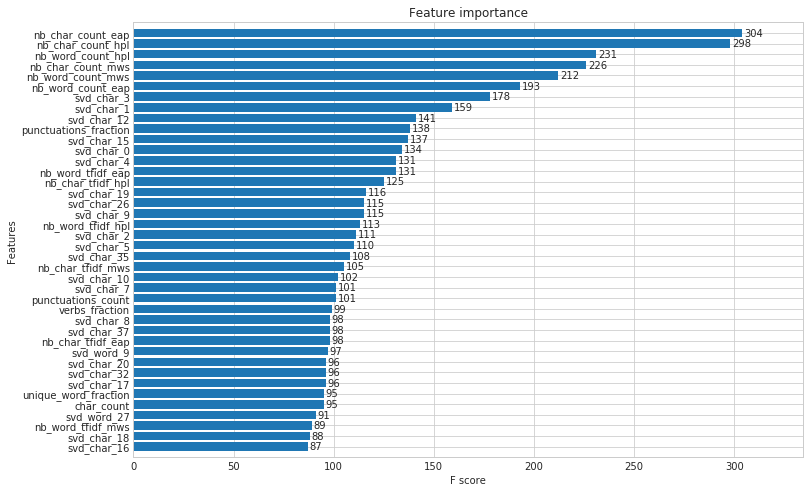

In [232]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

Confusion matrix, without normalization
[[1387   57   92]
 [  98 1019   51]
 [ 112   58 1042]]


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fd388b61358>>
Traceback (most recent call last):
  File "/home/guido/.conda/envs/dl/lib/python3.6/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


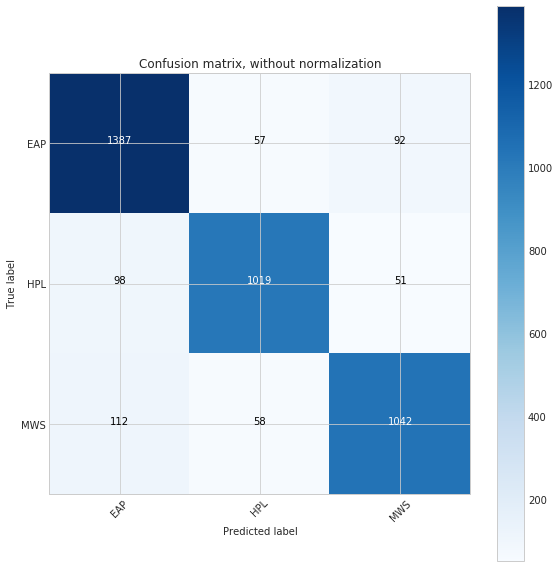

In [222]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

In [124]:
print(pred_train[:10])
print(pred_full_test[:10])

[[  9.98e-01   5.53e-04   1.53e-03]
 [  5.62e-01   3.87e-01   5.08e-02]
 [  9.97e-01   1.81e-03   1.00e-03]
 [  1.37e-03   1.27e-03   9.97e-01]
 [  7.59e-01   2.32e-01   9.27e-03]
 [  1.50e-02   3.71e-03   9.81e-01]
 [  9.84e-01   1.37e-02   1.84e-03]
 [  9.56e-01   2.42e-02   1.98e-02]
 [  9.22e-01   7.69e-02   1.27e-03]
 [  1.74e-01   5.49e-02   7.71e-01]]
[[  2.11e-02   4.29e-03   9.75e-01]
 [  9.99e-01   5.63e-04   4.85e-04]
 [  8.53e-02   9.00e-01   1.50e-02]
 [  7.45e-01   2.41e-01   1.41e-02]
 [  9.32e-01   3.20e-02   3.57e-02]
 [  9.60e-01   3.61e-02   4.16e-03]
 [  8.74e-01   1.17e-01   8.44e-03]
 [  1.37e-02   2.72e-01   7.15e-01]
 [  9.97e-01   8.16e-04   2.14e-03]
 [  9.81e-01   8.48e-03   1.01e-02]]


In [152]:
train_2 = train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
train_t = np.concatenate((pred_train, np.array(train_2)), axis=1)
print(train_t[:10])

test_2 = test[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
test_t = np.concatenate((pred_full_test, np.array(test_2)), axis=1)
print(test_t[:10])


train_t = pred_train
test_t = pred_full_test

[[  9.98e-01   5.53e-04   1.53e-03   1.00e+00   0.00e+00   0.00e+00]
 [  5.62e-01   3.87e-01   5.08e-02   7.33e-01   8.58e-01   1.00e-01]
 [  9.97e-01   1.81e-03   1.00e-03   9.91e-01   7.69e-02   2.31e-01]
 [  1.37e-03   1.27e-03   9.97e-01   0.00e+00   0.00e+00   1.00e+00]
 [  7.59e-01   2.32e-01   9.27e-03   5.00e-01   9.79e-01   0.00e+00]
 [  1.50e-02   3.71e-03   9.81e-01   5.00e-01   5.00e-01   9.81e-01]
 [  9.84e-01   1.37e-02   1.84e-03   9.58e-01   0.00e+00   7.50e-01]
 [  9.56e-01   2.42e-02   1.98e-02   1.00e+00   0.00e+00   0.00e+00]
 [  9.22e-01   7.69e-02   1.27e-03   1.00e+00   0.00e+00   0.00e+00]
 [  1.74e-01   5.49e-02   7.71e-01   0.00e+00   0.00e+00   1.00e+00]]
[[  2.11e-02   4.29e-03   9.75e-01   1.00e+00   0.00e+00   0.00e+00]
 [  9.99e-01   5.63e-04   4.85e-04   7.60e-01   2.00e-01   5.00e-01]
 [  8.53e-02   9.00e-01   1.50e-02   0.00e+00   0.00e+00   0.00e+00]
 [  7.45e-01   2.41e-01   1.41e-02   1.00e+00   1.00e+00   0.00e+00]
 [  9.32e-01   3.20e-02   3.57e-0

## train_test_split method

In [153]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(
    train_t, y_train, test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(test_t)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

model_2 = xgb.train(
    xgb_param,
    dtrain,
    2000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)

[0]	train-mlogloss:0.992304	valid-mlogloss:0.992101
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.314579	valid-mlogloss:0.315792
[80]	train-mlogloss:0.299427	valid-mlogloss:0.307013
[120]	train-mlogloss:0.292326	valid-mlogloss:0.306921
Stopping. Best iteration:
[107]	train-mlogloss:0.2944	valid-mlogloss:0.306552



In [150]:
pred_y_test = model_2.predict(dtest, ntree_limit=model_2.best_ntree_limit)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171127-05.csv", index=False)

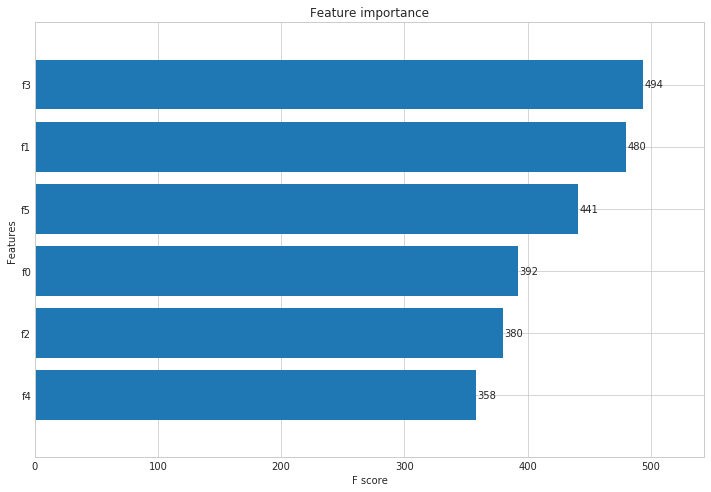

In [151]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model_2.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:20]),
    ax=ax,
    height=0.8)
plt.show()